#  有条件的生成对抗网络（Conditional Generative Adversarial Network）

背景知识：
* numpy.einsum：推荐观看此 [视频](https://www.bilibili.com/video/BV1XZ4y1Q7Ya/?spm_id_from=333.337.search-card.all.click&vd_source=4ce05641aa838b2a8f7ae5fd405de463)

生成对抗网络（GAN）是一种生成模型。它由两个部分组成，分别是“生成器”和“判别器”。生成器接受随机值作为输入，并将它们转换为（希望）类似于训练数据的输出。判别器接受一组样本作为输入，并试图将真正的训练样本与生成器创建的样本区分开来。他们都是一起接受训练的。判别器试图越来越好地区分真实数据和虚假数据，而生成器则试图越来越好地欺骗判别器。

有条件的 GAN （CGAN）允许向生成器和判别器输入附加的输出条件。例如，这可能是一个类标签，GAN 试图了解类之间的数据分布如何变化。

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Conditional_Generative_Adversarial_Networks.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands.

In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

在本例中，我们将创建一个由一组分布在椭圆中的二维数据，每个椭圆的位置、形状和方向都是随机的。每个类对应于一个不同的椭圆。让我们随机生成椭圆。对于每一个，我们选择一个随机的中心位置，X 和 Y 的大小和旋转角度。然后我们创建一个变换矩阵将单位圆映射到椭圆。（具体做法，我也没搞清楚，反正下面代码会生成四组shape为(1000,2)的数据集，每一组数据集都是在一个特定椭圆的范围内，四组数据集代表着四个椭圆，这四个数据集保存在points中，也就是说points的shape为(4,1000,2)，这四个椭圆是随机生成的）

In [1]:
import deepchem as dc
import numpy as np
import tensorflow as tf

n_classes = 4
class_centers = np.random.uniform(-4, 4, (n_classes, 2))
class_transforms = []
for i in range(n_classes):
    xscale = np.random.uniform(0.5, 2)
    yscale = np.random.uniform(0.5, 2)
    angle = np.random.uniform(0, np.pi)
    m = [[xscale*np.cos(angle), -yscale*np.sin(angle)],
         [xscale*np.sin(angle), yscale*np.cos(angle)]]
    class_transforms.append(m)
class_transforms = np.array(class_transforms)

该函数从分布中生成随机数据。对于每个点，它随机选择一个类，然后在该类椭圆中随机选择一个位置。

In [2]:
def generate_data(n_points):
    classes = np.random.randint(n_classes, size=n_points)
    r = np.random.random(n_points)
    angle = 2*np.pi*np.random.random(n_points)
    points = (r*np.array([np.cos(angle), np.sin(angle)])).T
    points = np.einsum('ijk,ik->ij', class_transforms[classes], points)
    points += class_centers[classes]
    return classes, points

我们从这个分布中画出一些随机点来看看它是什么样子的。点的颜色基于它们的类标签。（从图中可以看出，四个不同的颜色大致构成四个不同的椭圆）

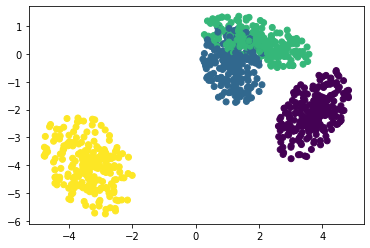

In [3]:
%matplotlib inline
import matplotlib.pyplot as plot
classes, points = generate_data(1000)
plot.scatter(x=points[:,0], y=points[:,1], c=classes)

现在让我们为 CGAN 创建模型。DeepChem 的 GAN 类使这变得非常容易。我们只是创建它的子类并编程一些方法。其中最重要的两个是：

- `create_generator()` 构建一个实现生成器的模型。该模型将一批随机噪声加上任何条件变量（在我们的例子中，每个样本的 one-hot 编码类）作为输入。它的输出是一个合成样本，应该与训练数据相似。

- `create_discriminator()` 构建一个实现判别器的模型。该模型将要评估的样本（可以是真实的训练数据，也可以是生成器创建的合成样本）和条件变量作为输入。它的输出是对应于每个样本的单个数字，这将被解释为样本是真实训练数据的概率。

在本例中，我们使用非常简单的模型。它们只是将输入连接在一起，并通过一些密集层。注意，判别器的最后一层使用了 sigmoid 激活函数。这确保它产生的输出在0到1之间，可以被解释为概率。

我们还需要编码一些定义各种输入形状的方法。我们规定提供给生成器的每个随机噪声样本应该由10个数字组成；每个数据样本包含两个数字（对应一个点的二维X坐标和Y坐标）；条件输入由每个样本的 `n_classes` 数字组成（one-hot 编码类索引）。

In [4]:
from tensorflow.keras.layers import Concatenate, Dense, Input

class ExampleGAN(dc.models.GAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(2,)]

  def get_conditional_input_shapes(self):
    return [(n_classes,)]

  def create_generator(self):
    noise_in = Input(shape=(10,))
    conditional_in = Input(shape=(n_classes,))
    gen_in = Concatenate()([noise_in, conditional_in])
    gen_dense1 = Dense(30, activation=tf.nn.relu)(gen_in)
    gen_dense2 = Dense(30, activation=tf.nn.relu)(gen_dense1)
    generator_points = Dense(2)(gen_dense2)
    return tf.keras.Model(inputs=[noise_in, conditional_in], outputs=[generator_points])

  def create_discriminator(self):
    data_in = Input(shape=(2,))
    conditional_in = Input(shape=(n_classes,))
    discrim_in = Concatenate()([data_in, conditional_in])
    discrim_dense1 = Dense(30, activation=tf.nn.relu)(discrim_in)
    discrim_dense2 = Dense(30, activation=tf.nn.relu)(discrim_dense1)
    discrim_prob = Dense(1, activation=tf.sigmoid)(discrim_dense2)
    return tf.keras.Model(inputs=[data_in, conditional_in], outputs=[discrim_prob])

gan = ExampleGAN(learning_rate=1e-4)

来拟合模型。我们通过调用 `fit_gan()` 来做到这一点。实参是一个生成批训练数据集的迭代器。更具体地说，它需要生成字典，将所有数据输入和条件输入映射到用于它们的值。在我们的例子中，我们可以很容易地创建任意数量的随机数据，因此我们定义了一个生成器，它为每批调用上面定义的 `generate_data()` 函数。

In [5]:
def iterbatches(batches):
  for i in range(batches):
    classes, points = generate_data(gan.batch_size)
    classes = dc.metrics.to_one_hot(classes, n_classes)
    yield {gan.data_inputs[0]: points, gan.conditional_inputs[0]: classes}

gan.fit_gan(iterbatches(5000))

Ending global_step 999: generator average loss 0.87121, discriminator average loss 1.08472
Ending global_step 1999: generator average loss 0.968357, discriminator average loss 1.17393
Ending global_step 2999: generator average loss 0.710444, discriminator average loss 1.37858
Ending global_step 3999: generator average loss 0.699195, discriminator average loss 1.38131
Ending global_step 4999: generator average loss 0.694203, discriminator average loss 1.3871
TIMING: model fitting took 31.352 s


让训练过的模型生成一些数据，看看它与我们之前绘制的训练分布匹配得有多好。

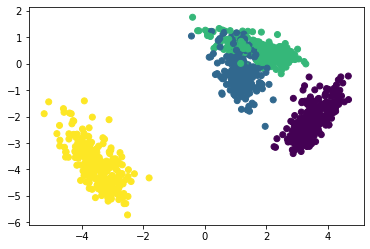

In [6]:
classes, points = generate_data(1000)
one_hot_classes = dc.metrics.to_one_hot(classes, n_classes)
gen_points = gan.predict_gan_generator(conditional_inputs=[one_hot_classes])
plot.scatter(x=gen_points[:,0], y=gen_points[:,1], c=classes)

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!